# **Training Sentiment Analysis Models with Tensorflow**



In [ ]:
# Connecting to Google Drive and retrieving the CSV file containing the reviews
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

%cd gdrive/MyDrive/[PATH]

In [2]:
# Importing the libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import nltk
import time
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Preparing the data**
To begin, we have to prepare the data, so that it is ready to be read by the models

In [3]:
# Reading the dataset and validating it
df = pd.read_csv('IMDB Dataset.csv', sep=',')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Removing break tags
df['review'] = df['review'].str.replace('<br />', '')
# Removing URLs
df['review'] = df['review'].str.replace(r'https?://\S+|www\.\S+', '')
# Removing punctuation
df['review'] = df['review'].str.replace(r'[^\w\s]+', '')
# Removing new line characters
df['review'] = df['review'].str.replace(r'\n', '')
# Converting the reviews to lowercase
df['review'] = df['review'].apply(str.lower)
# Validation
df.head()

<ipython-input-4-be9d0192fd8c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace(r'https?://\S+|www\.\S+', '')
<ipython-input-4-be9d0192fd8c>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace(r'[^\w\s]+', '')
<ipython-input-4-be9d0192fd8c>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace(r'\n', '')


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [5]:
import re
# Definition of function that does the above procedure of cleaning the data
def clean_text(text):
  text = re.sub('<br />', ' ',text)
  text = re.sub(r'https?://\S+|www\.\S+', ' ',text)
  text = re.sub(r'[^\w\s]+', ' ',text)
  text = re.sub(r'\n', ' ',text)
  text = text.lower()
  return str(text)

In [6]:
# Tokenization and Lemmatization of the reviews, Removing stop words
def lemmatize_text(text):
  stop_words = set(stopwords.words('english'))
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
  return [w for w in lemmatized if w not in stop_words]

df['review'] = df['review'].apply(lemmatize_text)

In [7]:
# Binarizing the sentiment
# 0 --> Negative
# 1 --> Positive
df['sentiment'] = df['sentiment'].replace('negative', 0.0)
df['sentiment'] = df['sentiment'].replace('positive', 1.0)
df.head()

,review,sentiment
0,"[one, reviewer, ha, mentioned, watching, 1, oz...",1.0
1,"[wonderful, little, production, filming, techn...",1.0
2,"[thought, wa, wonderful, way, spend, time, hot...",1.0
3,"[basically, family, little, boy, jake, think, ...",0.0
4,"[petter, matteis, love, time, money, visually,...",1.0


In [8]:
# Seeing how many positive and negative reviews there are
print("Positive Reviews: " + str((df['sentiment']==1.0).sum()))
print("Negative Reviews: " + str((df['sentiment']==0.0).sum()))

Positive Reviews: 25000
Negative Reviews: 25000


In [9]:
# Tokenizing the reviews to float vectors
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
max_words = 5000

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, num_words=max_words)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
reviews_temp = pad_sequences(sequences)
reviews = reviews_temp.astype(np.float32)

In [10]:
print(reviews)

[[0.000e+00 0.000e+00 0.000e+00 ... 7.840e+02 3.673e+03 3.510e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.753e+03 1.900e+01 1.340e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 3.300e+01 1.500e+01 1.150e+02]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 2.650e+02 3.900e+02 3.588e+03]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.844e+03 2.346e+03 6.030e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 8.980e+02 7.270e+02 1.000e+00]]


In [11]:
# Splitting to train and test data
from sklearn.model_selection import train_test_split

# Categorizing the labels "Positive" and "Negative"
labels = np.array(df['sentiment'])
labels = tf.keras.utils.to_categorical(labels, 2, dtype="float32")

X_train, X_test, y_train, y_test = train_test_split(reviews, labels, random_state=0, train_size=0.8, test_size=0.2)

# **Model Construction**
The models consist of an embedding (input) layer, a hidden layer (LSTM, Bidirectional LSTM) and a dense layer (output)

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint

# Single LSTM Layer Model
model1 = Sequential()
# We have max_words distinct words and we map them into vectors of size 20
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(20,dropout=0.3))
model1.add(layers.Dense(2,activation='softmax'))

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("LSTM.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=2,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/2
1250/1250 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8378
Epoch 1: val_accuracy improved from -inf to 0.88200, saving model to LSTM.hdf5
1250/1250 [==============================] - 127s 95ms/step - loss: 0.3616 - accuracy: 0.8378 - val_loss: 0.2852 - val_accuracy: 0.8820
Epoch 2/2
1249/1250 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8950
Epoch 2: val_accuracy improved from 0.88200 to 0.88920, saving model to LSTM.hdf5
1250/1250 [==============================] - 46s 37ms/step - loss: 0.2616 - accuracy: 0.8950 - val_loss: 0.2735 - val_accuracy: 0.8892


In [13]:
# Bidirectional LSTM Model
model2 = Sequential()
model2.add(layers.Embedding(max_words, 20))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.3)))
model2.add(layers.Dense(2,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("BiLSTM.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=2,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/2
1250/1250 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8320
Epoch 1: val_accuracy improved from -inf to 0.88410, saving model to BiLSTM.hdf5
1250/1250 [==============================] - 121s 94ms/step - loss: 0.3702 - accuracy: 0.8320 - val_loss: 0.2815 - val_accuracy: 0.8841
Epoch 2/2
1250/1250 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.8928
Epoch 2: val_accuracy improved from 0.88410 to 0.88440, saving model to BiLSTM.hdf5
1250/1250 [==============================] - 72s 57ms/step - loss: 0.2635 - accuracy: 0.8928 - val_loss: 0.2914 - val_accuracy: 0.8844


In [19]:
# Testing the first model
review = 'This cute animated short features two comic icons - Betty Boop and Henry.<br /><br />Henry is the bald, slightly portly boy from the comics who never speaks.<br /><br />Well here he does speak!<br /><br />He wants to get a puppy from Betty Boops pet store, and when he is left to mind the store - some hilarious hijinks ensue.<br /><br />Betty sings a song about pets, Henry gets in a battle with birds and a monkey, but everything works out in the end.'
cleaned = clean_text(review)
lemmatized = lemmatize_text(cleaned)
sequence = tokenizer.texts_to_sequences(lemmatized)
review_temp = pad_sequences(sequence)
review = review_temp.astype(np.float32)
prediction = model1.predict(review)

2/2 [==============================] - 0s 5ms/step


In [20]:
print(prediction)

[[0.49335474 0.50664526]
 [0.42232576 0.57767427]
 [0.44964248 0.5503575 ]
 [0.5241526  0.47584745]
 [0.5328421  0.46715793]
 [0.41016546 0.5898346 ]
 [0.4871574  0.51284266]
 [0.41872784 0.5812721 ]
 [0.5233345  0.4766655 ]
 [0.45808244 0.5419175 ]
 [0.45808244 0.5419175 ]
 [0.5233345  0.4766655 ]
 [0.49509588 0.50490415]
 [0.5233345  0.4766655 ]
 [0.48659435 0.5134057 ]
 [0.41016546 0.5898346 ]
 [0.51756066 0.48243934]
 [0.58433026 0.41566974]
 [0.37309277 0.6269072 ]
 [0.55656683 0.4434331 ]
 [0.5270482  0.47295183]
 [0.56597924 0.4340208 ]
 [0.4616829  0.5383171 ]
 [0.5233345  0.4766655 ]
 [0.41872784 0.5812721 ]
 [0.5233345  0.4766655 ]
 [0.52779055 0.47220948]
 [0.5574953  0.44250476]
 [0.6531915  0.34680852]
 [0.4299251  0.57007486]
 [0.5574953  0.44250476]
 [0.21766633 0.7823337 ]
 [0.5233345  0.4766655 ]
 [0.5233345  0.4766655 ]
 [0.41872784 0.5812721 ]
 [0.40987334 0.59012663]
 [0.51394033 0.48605967]
 [0.52779055 0.47220948]
 [0.45808244 0.54191756]
 [0.46168292 0.5383171 ]


# **Interpreting the predicted values**
In this section there are three ways to interpret the predicted values:

1.   Using the mean value of each column
2.   By counting the occurences of each label (positive / negative)
3.   By keeping only the values above a certain threshold




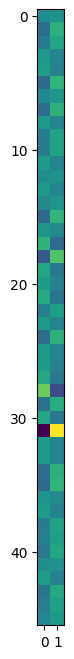

In [21]:
# Visualizing the prediction
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(prediction)
plt.show()

In [22]:
# Interpreting the output by taking the average of every column
avg = prediction.mean(axis=0)

print(avg[0] * 100, "% negative")
print(avg[1] * 100, "% positive\n")

if(avg[0]>avg[1]):
  print("The review is negative")
elif(avg[0]<avg[1]):
  print("The review is positive")
else:
  print("The review is neutral")


48.4814316034317 % negative
51.51857137680054 % positive

The review is positive


In [23]:
# Interpreting the output by categorizing every word and then counting the positive and the negative words
classified = []

for item in prediction:
  if item[0] > item[1]:
    classified.append(0)
  else:
      classified.append(1)

positive = sum(classified)
negative = len(classified) - positive

print("Positive words: ", positive)
print("Negative words: ", negative)

if(positive > negative):
  print("The review is positive")
elif (positive < negative):
  print("The review is negative")
else:
  print("The review is neutral")

Positive words:  25
Negative words:  21
The review is positive


In [24]:
# Keeping only the values which are equal or greater than the threshold and then using the 2 above evaluation ways to interpret the output
threshold = 0.6
sorted_values = []

for item in prediction:
  if(item[0] >= threshold or item[1] >= threshold):
    sorted_values.append(item)

sorted_values = np.array(sorted_values)

# Interpreting using the average
print("Using the Mean Value:\n")

avg = sorted_values.mean(axis=0)

print(avg[0] * 100, "% negative")
print(avg[1] * 100, "% positive")

if(avg[0]>avg[1]):
  print("The review is negative")
elif(avg[0]<avg[1]):
  print("The review is positive")
else:
  print("The review is neutral")

# Interpreting the output by categorizing every word and then counting the positive and the negative words
print("\nBy counting the positive and negative words:\n")

classified = []

for item in sorted_values:
  if item[0] > item[1]:
    classified.append(0)
  else:
      classified.append(1)

positive = sum(classified)
negative = len(classified) - positive

print("Positive words: ", positive)
print("Negative words: ", negative)

if(positive > negative):
  print("The review is positive")
elif (positive < negative):
  print("The review is negative")
else:
  print("The review is neutral")

Using the Mean Value:

41.465020179748535 % negative
58.534979820251465 % positive
The review is positive

By counting the positive and negative words:

Positive words:  2
Negative words:  1
The review is positive


# **Distributed training strategies**
In this section there is the code for 4 different strategies:


1.   Mirrored Strategy
2.   TPU Strategy
3.   Central Storage Strategy
4.   Parameter Server Strategy



In [ ]:
# Testing Mirrored Strategy
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint

strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
  model1 = Sequential()
  model1.add(layers.Embedding(max_words, 20))
  model1.add(layers.LSTM(20,dropout=0.3))
  model1.add(layers.Dense(2,activation='softmax'))
  model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)

history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

In [ ]:
# Create a TPUClusterResolver object
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')

# Get the number of available TPUs
num_tpus = resolver.num_accelerators()

print("Number of available TPUs: ", num_tpus)

# Testing the TPU Strategy
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
# TPU Strategy
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
  model1 = Sequential()
  model1.add(layers.Embedding(max_words, 20))
  model1.add(layers.LSTM(20,dropout=0.3))
  model1.add(layers.Dense(2,activation='softmax'))
  model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)

history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[tensorboard_callback])

In [ ]:
# Central Storage Strategy
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint

strategy = tf.distribute.experimental.CentralStorageStrategy()

with strategy.scope():
  model1 = Sequential()
  model1.add(layers.Embedding(max_words, 20))
  model1.add(layers.LSTM(20,dropout=0.3))
  model1.add(layers.Dense(2,activation='softmax'))
  model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)

start = time.time()
history = model1.fit(X_train, y_train, epochs=2,validation_data=(X_test, y_test),callbacks=[checkpoint1])
end = time.time()
print(end - start)

In [ ]:
# Parameter Server Strategy
# Prepare a strategy to use with the cluster and variable partitioning info.
strategy = tf.distribute.experimental.ParameterServerStrategy(
    cluster_resolver=...,
    variable_partitioner=...)

# A dataset function takes a `input_context` and returns a `Dataset`
def dataset_fn(input_context):
  dataset = tf.data.Dataset.from_tensors(...)
  return dataset.repeat().shard(...).batch(...).prefetch(...)

# With `Model.fit`, a `DatasetCreator` needs to be used.
input = tf.keras.utils.experimental.DatasetCreator(dataset_fn=...)

with strategy.scope():
  model = ...  # Make sure the `Model` is created within scope.
model.compile(optimizer="rmsprop", loss="mse", steps_per_execution=..., ...)

# Optional callbacks to checkpoint the model, back up the progress, etc.
callbacks = [tf.keras.callbacks.ModelCheckpoint(...), ...]

# `steps_per_epoch` is required with `ParameterServerStrategy`.
model.fit(input, epochs=..., steps_per_epoch=..., callbacks=callbacks)